# Evaluation


In [8]:
import sys
sys.path.append('../') #act as if we are one directory higher so imports work 
import torch
from latent_to_timestep_model import LTT_model
from dataset import load_data_from_dir

In [14]:
path = "/netpool/homes/connor/DiffusionModels/LD3_connor/train_data/train_data_cifar10/uni_pc_NFE20_edm_seed0"
latents, targets, conditions, unconditions = load_data_from_dir(data_folder=path, limit=200)


In [16]:
latents[0].fo


torch.Size([3, 32, 32])

## LTT Model

In [29]:
ltt_model = LTT_model()
model_path_450 = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train450-rv12-seed0/final_ltt_model.pt"
model_path_50 = "/netpool/homes/connor/DiffusionModels/LD3_connor/logs/logs_cifar10/N10-val50-train50-rv12-seed0/ltt_model.pt"
state_dict = torch.load(model_path_50, weights_only=True)
ltt_model.load_state_dict(state_dict)  # Load the model state

<All keys matched successfully>

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(ltt_model))

19264111


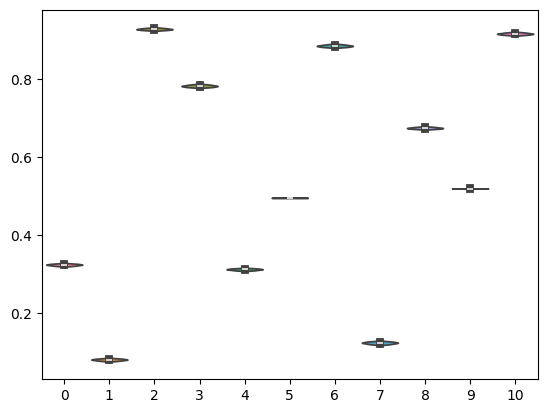

In [31]:
params_list = [ltt_model.forward(latent) for latent in latents]
params_list = torch.stack(params_list)

#visualize as violin plot over each of the 10 timesteps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

params_list = params_list.detach().numpy()
params_list = params_list.reshape(-1, 11)
params_list = pd.DataFrame(params_list, columns=[f"{i}" for i in range(11)])
sns.violinplot(data=params_list)
plt.show()


In [32]:
params_list

,0,1,2,3,4,5,6,7,8,9,10
0,0.324003,0.080537,0.927705,0.781876,0.312145,0.495137,0.884678,0.123774,0.674043,0.519087,0.915741
1,0.321942,0.078425,0.929663,0.784356,0.310245,0.495181,0.887099,0.121179,0.675912,0.519259,0.917962
2,0.323896,0.080430,0.927808,0.781999,0.312052,0.495151,0.884811,0.123648,0.674141,0.519099,0.915857
3,0.320216,0.076694,0.931269,0.786415,0.308657,0.495229,0.889104,0.119046,0.677480,0.519405,0.919786
4,0.322672,0.079173,0.928977,0.783471,0.310930,0.495182,0.886257,0.122106,0.675249,0.519209,0.917181
...,...,...,...,...,...,...,...,...,...,...,...
195,0.320776,0.077250,0.930754,0.785752,0.309176,0.495211,0.888457,0.119731,0.676969,0.519364,0.919199
196,0.323771,0.080299,0.927931,0.782153,0.311940,0.495152,0.884961,0.123486,0.674252,0.519116,0.915995
197,0.326580,0.083244,0.925196,0.778752,0.314524,0.495099,0.881609,0.127083,0.671711,0.518874,0.912899
198,0.323076,0.079581,0.928596,0.782993,0.311299,0.495163,0.885779,0.122604,0.674881,0.519175,0.916748
